# Analysis of the School Budget Data

Author: Tom Freudenmann
Date: 2024-17-01
Tags: Analysis, School, Budget, Data
Summary: This is the analysis of the school budgets in Germany.


In [3]:
from school_analysis.preprocessing.load import Loader
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import school_analysis as sa
from school_analysis.preprocessing.helpers import students_teachers
from tueplots.constants.color import rgb
from school_analysis.analysis.exploration import Exploration
from school_analysis.analysis.aggregation import Aggregation
from school_analysis.plotting.general import GeneralPlots

FEDERAL_STATES= {
    "Old Federal States": ["Schleswig-Holstein", "Niedersachsen", "Bremen", "Hamburg", "Nordrhein-Westfalen", "Hessen", "Rheinland-Pfalz", "Saarland", "Baden-Württemberg", "Bayern"],
    "New Federal States": ["Mecklenburg-Vorpommern", "Brandenburg", "Berlin", "Sachsen", "Sachsen-Anhalt", "Thüringen"]
}

loader = Loader()

budgets_per_child = loader.load("budgets-per-child-by-state")
budgets = loader.load("budgets-by-state")
verbraucherpreisindex = loader.load("verbraucherpreisindex-state")

In [4]:
display(budgets_per_child, budgets, verbraucherpreisindex)

,Federal State,Year,Budget
0,Baden-Württemberg,2010,6100
1,Bayern,2010,6400
2,Berlin,2010,7000
3,Brandenburg,2010,6200
4,Bremen,2010,6100
...,...,...,...
199,Sachsen,2021,8700
200,Sachsen-Anhalt,2021,8600
201,Schleswig-Holstein,2021,8600
202,Thüringen,2021,9500


,Institution,Year,Measure,Unit,Value,Federal State
0,Child day care,1995,Public expenditure on education,EUR 1000,242182.09,Baden-Württemberg
1,Child day care,1995,Public expenditure on education,EUR 1000,377243.42,Bayern
2,Child day care,1995,Public expenditure on education,EUR 1000,NaN,Berlin
3,Child day care,1995,Public expenditure on education,EUR 1000,206027.11,Brandenburg
4,Child day care,1995,Public expenditure on education,EUR 1000,48907.11,Bremen
...,...,...,...,...,...,...
39899,Total,2023,Prop. of ed. exp. of pub.budgets of overall bu...,percent,24.32,Saarland
39900,Total,2023,Prop. of ed. exp. of pub.budgets of overall bu...,percent,27.83,Sachsen
39901,Total,2023,Prop. of ed. exp. of pub.budgets of overall bu...,percent,25.89,Sachsen-Anhalt
39902,Total,2023,Prop. of ed. exp. of pub.budgets of overall bu...,percent,25.58,Schleswig-Holstein


,Year,Federal State,Index,Year Relative
0,1995,Baden-Württemberg,0.705,2020
1,1996,Baden-Württemberg,0.713,2020
2,1997,Baden-Württemberg,0.725,2020
3,1998,Baden-Württemberg,0.732,2020
4,1999,Baden-Württemberg,0.736,2020
...,...,...,...,...
459,2019,Thüringen,0.988,2020
460,2020,Thüringen,1.000,2020
461,2021,Thüringen,1.032,2020
462,2022,Thüringen,1.109,2020


## 1. Budget Analysis per Child

In [38]:
def plot_budgets_per_child(plot_data, value_col="Budget"):
    fig, ax = plt.subplots(1, 1)

    mean_d = plot_data.groupby("Year").apply(lambda x: x[value_col].mean()).reset_index().rename(columns={0: value_col})
    std_d = plot_data.groupby("Year").apply(lambda x: x[value_col].std()).reset_index().rename(columns={0: value_col})
    ax.plot(mean_d["Year"], mean_d[value_col], label="Mean", linestyle="--")
    ax.fill_between(mean_d["Year"], mean_d[value_col] - std_d[value_col], mean_d[value_col] + std_d[value_col], alpha=0.25, label="Std-Deviation",  color=rgb.tue_gray)

    label_set = False
    for state in plot_data["Federal State"].unique():
        state_data = plot_data[plot_data["Federal State"] == state]
        label = "Single States" if not label_set else None
        label_set = True
        ax.plot(state_data["Year"], state_data[value_col], color=rgb.tue_dark, alpha=0.2, label=label)
    
    return fig, ax

### 1.1 First feeling for the data

Text(0.5, 0.98, 'Budget per child by year')

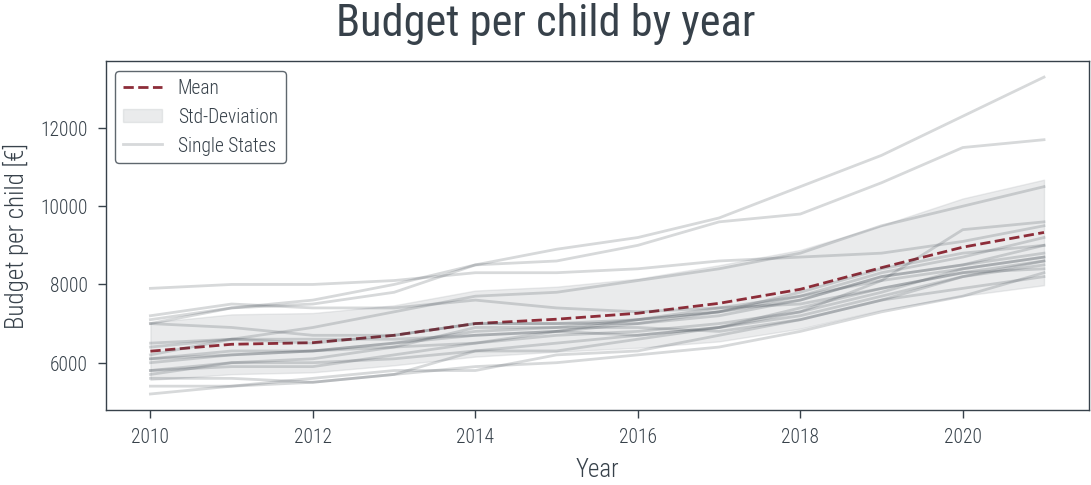

In [40]:
plot_data = budgets_per_child.copy()
fig, ax = plot_budgets_per_child(plot_data, value_col="Budget")

ax.legend()
ax.set_xlabel("Year")
ax.set_ylabel("Budget per child [€]")
fig.suptitle("Budget per child by year", fontsize=16)

In [68]:
def plot_budgets_per_child_by_state(plot_data, value_col="Budget"):
    fig, axs = plt.subplots(1, 2, sharey=True)

    for i, fs in enumerate(FEDERAL_STATES):
        label_set = False
        ax = axs[i]
        
        # Calculate the mean and stdS
        plot_data_fs = plot_data[plot_data["Federal State"].isin(FEDERAL_STATES[fs])].copy()
        plot_data_fs_mean = plot_data_fs.groupby(["Year"]).apply(lambda x: x[value_col].mean()).reset_index().rename(columns={0: value_col})
        plot_data_std_fs = plot_data_fs.groupby(["Year"]).apply(lambda x: x[value_col].std()).reset_index().rename(columns={0: value_col})

        # Plot the mean (by federal state group) and std
        ax.plot(plot_data_fs_mean["Year"], plot_data_fs_mean[value_col], label="Mean".format(fs), color=rgb.tue_gold, linestyle='--')
        ax.fill_between(plot_data_fs_mean["Year"], plot_data_fs_mean[value_col] - plot_data_std_fs[value_col], plot_data_fs_mean[value_col] + plot_data_std_fs[value_col], alpha=0.25, label="Std-Deviation",  color=rgb.tue_gray)
        
        for state in FEDERAL_STATES[fs]:
            if state not in plot_data_fs["Federal State"].unique():
                print("State {} not in data".format(state))
                continue
            
            # Get the data of the federal state and get the number of Budget mean over all contract types
            plot_data_state = plot_data_fs[plot_data_fs["Federal State"] == state]
            ax.plot(plot_data_state["Year"], plot_data_state[value_col], color=rgb.tue_dark, alpha=0.2, label="Single States" if not label_set else "")
            label_set = True
        
        ax.set_xticks(np.arange(plot_data_fs_mean["Year"].min() + 1, plot_data_fs_mean["Year"].max() + 1, 4))
        ax.grid(True)
        ax.set_xlabel("Year")

        # Settings
        axs[0].set_title("Old Federal States")
        axs[1].set_title("New Federal States")
        axs[1].legend(bbox_to_anchor=(1, 0.9), title="Federal State")
        
        
    return fig, axs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


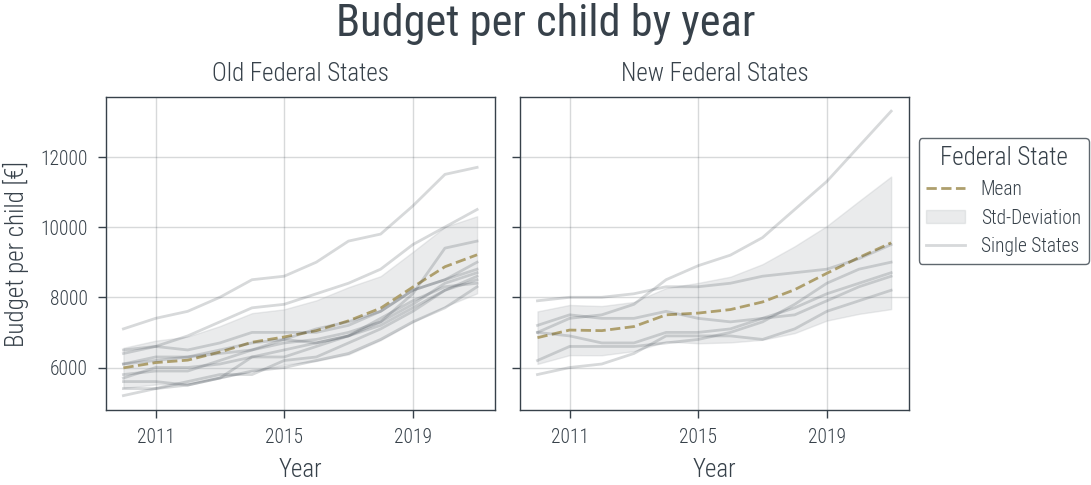

In [69]:
# Get the right data
plot_data = budgets_per_child.copy()
fig, axs = plot_budgets_per_child_by_state(plot_data, value_col="Budget")
axs[0].set_ylabel("Budget per child [€]")

# Other settings
fig.suptitle("Budget per child by year", fontsize=16);

### 1.2. Budget Analysis per Child and compared to the verbraucherpreisindex

In [70]:
display(verbraucherpreisindex, budgets_per_child)

,Year,Federal State,Index,Year Relative
0,1995,Baden-Württemberg,0.705,2020
1,1996,Baden-Württemberg,0.713,2020
2,1997,Baden-Württemberg,0.725,2020
3,1998,Baden-Württemberg,0.732,2020
4,1999,Baden-Württemberg,0.736,2020
...,...,...,...,...
459,2019,Thüringen,0.988,2020
460,2020,Thüringen,1.000,2020
461,2021,Thüringen,1.032,2020
462,2022,Thüringen,1.109,2020


,Federal State,Year,Budget
0,Baden-Württemberg,2010,6100
1,Bayern,2010,6400
2,Berlin,2010,7000
3,Brandenburg,2010,6200
4,Bremen,2010,6100
...,...,...,...
199,Sachsen,2021,8700
200,Sachsen-Anhalt,2021,8600
201,Schleswig-Holstein,2021,8600
202,Thüringen,2021,9500


In [71]:
budget_by_child_ver_index = pd.merge(budgets_per_child, verbraucherpreisindex, on=["Year", "Federal State"], how="left")
budget_by_child_ver_index["Reference Budget"] = budget_by_child_ver_index["Budget"] / budget_by_child_ver_index["Index"]
budget_by_child_ver_index

,Federal State,Year,Budget,Index,Year Relative,Reference Budget
0,Baden-Württemberg,2010,6100,0.880,2020.0,6931.818182
1,Bayern,2010,6400,0.876,2020.0,7305.936073
2,Berlin,2010,7000,0.877,2020.0,7981.755986
3,Brandenburg,2010,6200,0.887,2020.0,6989.853439
4,Bremen,2010,6100,0.875,2020.0,6971.428571
...,...,...,...,...,...,...
199,Sachsen,2021,8700,1.032,2020.0,8430.232558
200,Sachsen-Anhalt,2021,8600,1.032,2020.0,8333.333333
201,Schleswig-Holstein,2021,8600,1.030,2020.0,8349.514563
202,Thüringen,2021,9500,1.032,2020.0,9205.426357


Text(0.5, 0.98, 'Budget per child by year (Normalized 2020)')

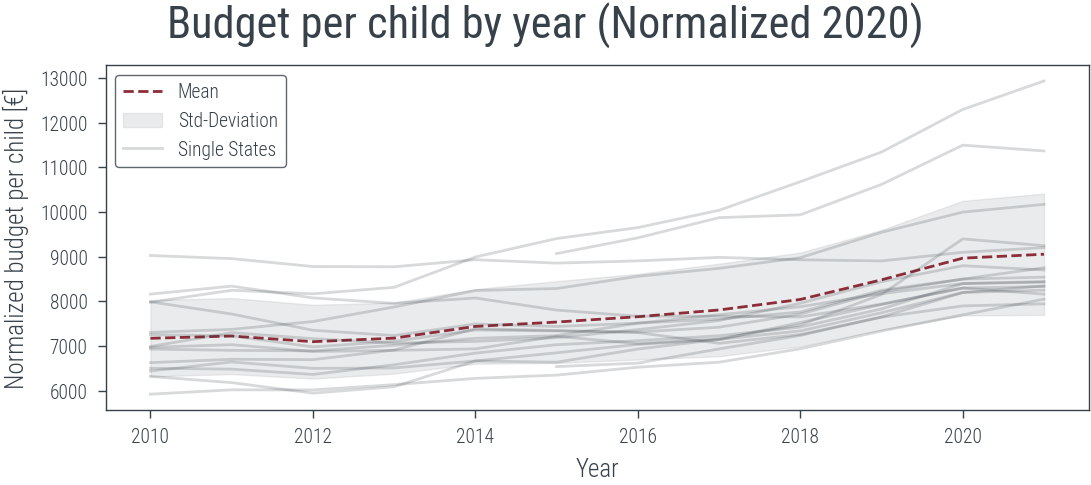

In [72]:
plot_data = budget_by_child_ver_index.copy()
fig, ax = plot_budgets_per_child(plot_data, value_col="Reference Budget")

ax.legend()
ax.set_xlabel("Year")
ax.set_ylabel("Normalized budget per child [€]")
fig.suptitle("Budget per child by year (Normalized 2020)", fontsize=16)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


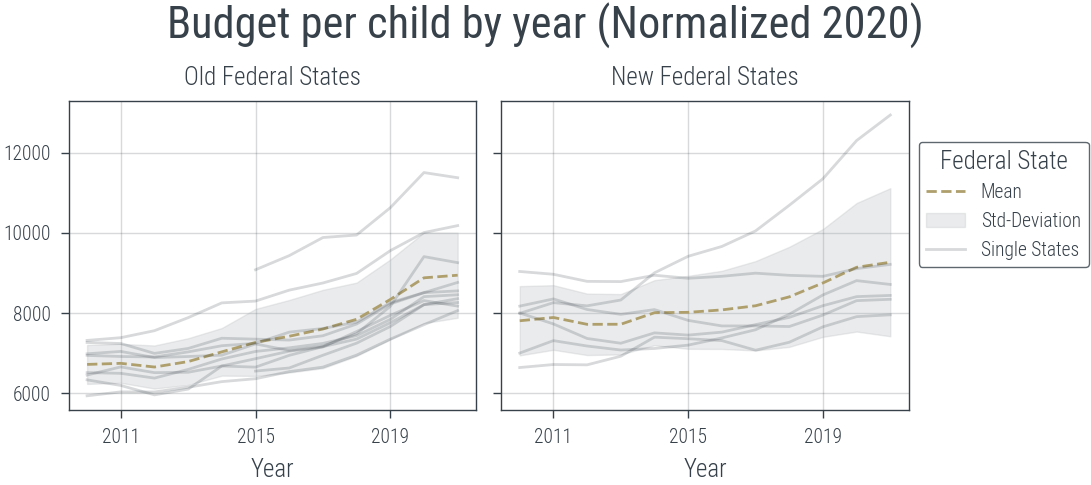

In [73]:
plot_data = budget_by_child_ver_index.copy()
fig, ax = plot_budgets_per_child_by_state(plot_data, value_col="Reference Budget")

axs[0].set_ylabel("Normalized Budget per child [€]")
# Other settings
fig.suptitle("Budget per child by year (Normalized 2020)", fontsize=16);